In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data overview

https://www.kaggle.com/competitions/mercari-price-suggestion-challenge/data

## Loading

In [2]:
data = Path('../data')

In [29]:
df = pd.read_table(data/'train.tsv')
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [32]:
(df.item_description=='No description yet').sum()

82489

In [4]:
df.shape

(1482535, 8)

## Categories

In [5]:
categorical = []

### item_condition_id

The condition of the items provided by the seller

In [6]:
df.item_condition_id.value_counts()

1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64

In [7]:
categorical.append('item_condition_id')

### category_name

Category of the listing.

In [8]:
df.category_name.value_counts()

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
                                                  ...  
Handmade/Dolls and Miniatures/Primitive               1
Handmade/Pets/Tag                                     1
Handmade/Patterns/Accessories                         1
Home/Kids' Home Store/Nursery Furniture               1
Handmade/Pets/Blanket                                 1
Name: category_name, Length: 1287, dtype: int64

There seems to be a structure to the categories. Maybe later they can be split into levels?

There are some missing categories:

In [9]:
df.category_name.isna().sum()

6327

For now we won't treat them differently, as fastai handles missing values.

In [10]:
categories = list(df.category_name.unique())

splits = []
for cat in categories:
    if isinstance(cat, str):
        splits.append(cat.split('/'))

In [11]:
counts = [len(split) for split in splits]
set(counts)

{3, 4, 5}

In [12]:
top_level_cats = pd.Series([split[0] for split in splits])
top_level_cats.value_counts()

Handmade                  293
Vintage & Collectibles    195
Kids                      159
Women                     153
Home                      133
Men                       109
Other                      73
Electronics                59
Beauty                     58
Sports & Outdoors          55
dtype: int64

In [13]:
cat_df = pd.DataFrame(df.category_name.str.split('/', n=5, expand=True))
cat_df.head()

,0,1,2,3,4
0,Men,Tops,T-shirts,None,None
1,Electronics,Computers & Tablets,Components & Parts,None,None
2,Women,Tops & Blouses,Blouse,None,None
3,Home,Home Décor,Home Décor Accents,None,None
4,Women,Jewelry,Necklaces,None,None


In [14]:
cat_df.rename(columns={0: 'Cat1', 1: 'Cat2', 2: 'Cat3', 3: 'Cat4', 4: 'Cat5'}, inplace=True)
cat_df.head()

,Cat1,Cat2,Cat3,Cat4,Cat5
0,Men,Tops,T-shirts,None,None
1,Electronics,Computers & Tablets,Components & Parts,None,None
2,Women,Tops & Blouses,Blouse,None,None
3,Home,Home Décor,Home Décor Accents,None,None
4,Women,Jewelry,Necklaces,None,None


In [15]:
len(cat_df)

1482535

In [16]:
df = pd.concat([df, cat_df], axis=1)
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,Cat1,Cat2,Cat3,Cat4,Cat5
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,None,None
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,None,None
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,None,None
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,None,None
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,None,None


In [17]:
categorical += ["Cat1",	"Cat2",	"Cat3",	"Cat4",	"Cat5"]

### brand_name

In [18]:
df.brand_name.value_counts()

PINK                    54088
Nike                    54043
Victoria's Secret       48036
LuLaRoe                 31024
Apple                   17322
                        ...  
The Learning Journey        1
Pampers Baby Fresh          1
Huggies One & Done          1
Classic Media               1
Kids Only                   1
Name: brand_name, Length: 4809, dtype: int64

There seem to be lots of brands that only occur a few times.

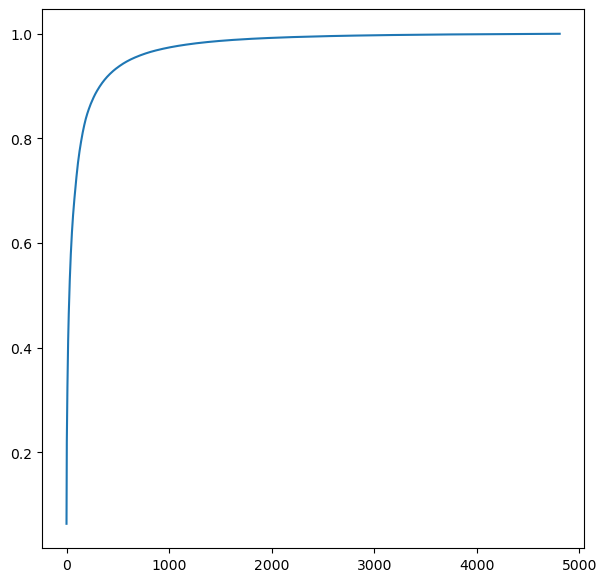

In [19]:
value_counts = df.brand_name.value_counts()
names = value_counts.index
counts = value_counts.values

fig, ax = plt.subplots(figsize=(7,7))

ax.plot(np.cumsum(counts)/np.sum(counts))

plt.show()

In [20]:
len([name for name,count in df.brand_name.value_counts().items() if count<10])

3055

**IDEA**
It might be beneficial to group those into a 'nameless_brand' category.

In [21]:
categorical.append('brand_name')

## floats

### shipping

 If shipping fee is paid by seller and 0 by buyer

In [22]:
df.shipping.value_counts()

0    819435
1    663100
Name: shipping, dtype: int64

Slightly more 0-shippings than 1 shippings, but should be ok.

# Training set

### Price cutoff

In [26]:
df['description_len'] = df.item_description.str.len()

cutoff = np.percentile(df.price, 99)
df = df[df.price<=cutoff].reset_index()

In [27]:
columns = categorical + ['shipping', 'price', 'description_len']

train = df.loc[:, columns]

In [28]:
train.to_feather(data/'train_desc_len.feather')

In [ ]:
categorical

['item_condition_id', 'Cat1', 'Cat2', 'Cat3', 'Cat4', 'Cat5', 'brand_name']